# Importing Libraries:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Question 1:
from scipy.integrate import quad
from scipy.stats import norm, laplace

# Question 2:
from skimage import io , util
import cv2
from collections import defaultdict

# Question 1:

In [8]:
# Define parameters:
sigma_X = 1
sigma_Z = np.sqrt(0.1)

# Defining density functions:
def g_joint_yx(x,y,sigma_X,sigma_Z):
  gauss_part = norm.pdf(y - x, loc=0, scale=sigma_Z)
  laplace_part = laplace.pdf(x, loc=0, scale=sigma_X)
  return gauss_part * laplace_part

# Define the range of y
y_values = np.linspace(-2, 2, 1000)

# Initialize an empty list to store the X_estimate values
X_estimate_values = []

# For each y value, compute X_estimate and add it to the list
for i,y in enumerate(y_values):
    numerator, _ = quad(lambda x: x * g_joint_yx(x, y, sigma_X, sigma_Z), -np.inf, np.inf)
    denominator, _ = quad(lambda x: g_joint_yx(x, y, sigma_X, sigma_Z), -np.inf, np.inf)
    X_estimate = numerator / denominator
    X_estimate_values.append(X_estimate)

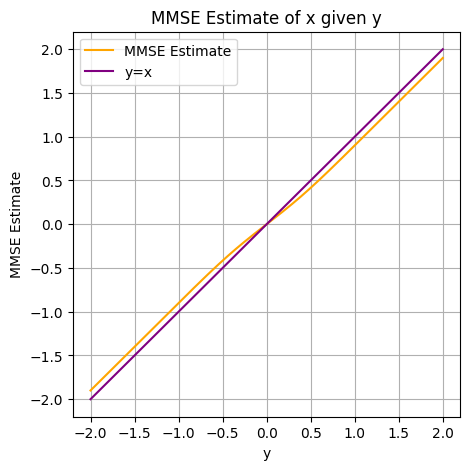

In [9]:
plt.figure(figsize=(5, 5))
plt.plot(y_values, X_estimate_values,color='orange', label='MMSE Estimate')
plt.plot(y_values, y_values, color= 'purple', label='y=x')
plt.xlabel('y')
plt.ylabel('MMSE Estimate')
plt.title('MMSE Estimate of x given y')
plt.legend()
plt.grid(True)
plt.show()

# Question 2:

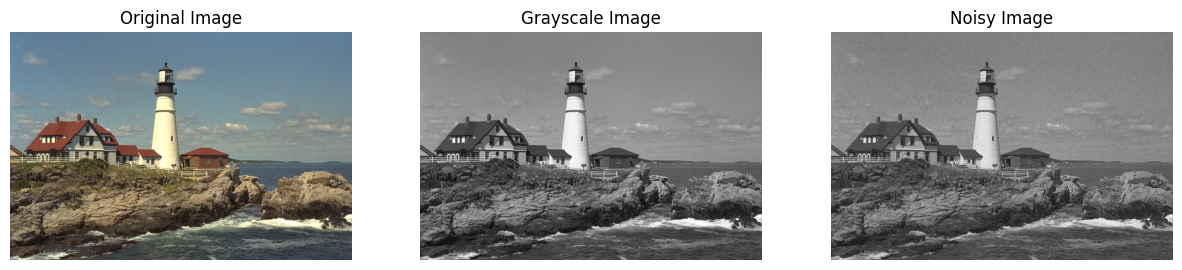

MSE corresponding to noisy image is 99.7934


In [10]:
# Importing Image

image_path = '/content/lighthouse2.bmp'
image = np.array(io.imread(image_path))


# Convert image to grayscale
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Add Gaussian Noise
gaussian_noise = np.random.normal(0,10,grayscale_image.shape) # Mean = 0, Standard Deviation = 10 (Variance = 100)

noisy_image = grayscale_image + gaussian_noise

# Displaying
fig,axs = plt.subplots(1,3,figsize = (15,8))

axs[0].imshow(image)
axs[0].axis('off')
axs[0].set_title('Original Image')

axs[1].imshow(grayscale_image, cmap = 'gray')
axs[1].axis('off')
axs[1].set_title('Grayscale Image')

axs[2].imshow(noisy_image, cmap = 'gray')
axs[2].axis('off')
axs[2].set_title('Noisy Image')

plt.show()

print(f"MSE corresponding to noisy image is {np.round(np.mean((grayscale_image.astype('float') - noisy_image.astype('float'))**2),4)}")

## **Question 2**,Part 1:

In [11]:
class LPF_gaussian:
  def __init__(self,original_image,noisy_image):
    self.height = image.shape[0]
    self.width = image.shape[1]
    self.original_image = original_image
    self.noisy_image = noisy_image
    self.MSE_values = None
    self.image_stack = None
    self.min_MSE = None

  def MSE(self,image1,image2):
    return np.mean((image1.astype('float') - image2.astype('float'))**2)

  def nested_dict(self):
    return defaultdict(lambda: defaultdict(dict))

  def compute_MSE(self,kernel_size_list,std_dev_list):

    MSE_dict = self.nested_dict()
    Image_stack = self.nested_dict()

    min_MSE = [float('inf'),0,0]
    for size in kernel_size_list:
      for sigma in std_dev_list:
        # Denoising Attempt using Gaussian LPF filter:
        blurred_image = cv2.GaussianBlur(self.noisy_image.copy(),(size, size),sigma)
        # Computing MSE wrt original image
        mse = self.MSE(self.original_image.copy(),blurred_image.copy())

        # Checking if the the computed MSE is minimum
        if mse < min_MSE[0]:
          min_MSE[0] = round(mse, 4)
          min_MSE[1] = size
          min_MSE[2] = sigma

        MSE_dict[size][sigma] = round(mse, 4)
        Image_stack[size][sigma] = blurred_image

    def dict_conversion(d):
      if isinstance(d, dict):
        d = {k: dict_conversion(v) for k, v in d.items()}
      return d

    self.min_MSE = min_MSE
    self.MSE_values = dict_conversion(MSE_dict)
    self.image_stack = Image_stack



In [12]:
question_2a = LPF_gaussian(grayscale_image.copy(), noisy_image.copy())

kernel_size_list = [3, 7, 11]
std_dev_list =  [0.1, 1, 2, 4, 8]
question_2a.compute_MSE(kernel_size_list,std_dev_list)

#### **Comparison**:

In [13]:
MSE_Values = question_2a.MSE_values
for kernel_size,inner_dict in MSE_Values.items():
  print("For kernel size", kernel_size,)
  for sigma,mse_value in inner_dict.items():
    print(f"Standard deviation is {sigma} and MSE is: {mse_value}")

min_MSE = question_2a.min_MSE
print(f"\nMinimum MSE observed is {min_MSE[0]}, with kernel size = {min_MSE[1]} and standard deviation = {min_MSE[2]}")

For kernel size 3
Standard deviation is 0.1 and MSE is: 99.7934
Standard deviation is 1 and MSE is: 89.406
Standard deviation is 2 and MSE is: 110.109
Standard deviation is 4 and MSE is: 115.4819
Standard deviation is 8 and MSE is: 116.827
For kernel size 7
Standard deviation is 0.1 and MSE is: 99.7934
Standard deviation is 1 and MSE is: 114.1739
Standard deviation is 2 and MSE is: 214.7173
Standard deviation is 4 and MSE is: 261.2325
Standard deviation is 8 and MSE is: 274.2319
For kernel size 11
Standard deviation is 0.1 and MSE is: 99.7934
Standard deviation is 1 and MSE is: 114.2213
Standard deviation is 2 and MSE is: 229.6199
Standard deviation is 4 and MSE is: 318.1376
Standard deviation is 8 and MSE is: 350.2898

Minimum MSE observed is 89.406, with kernel size = 3 and standard deviation = 1


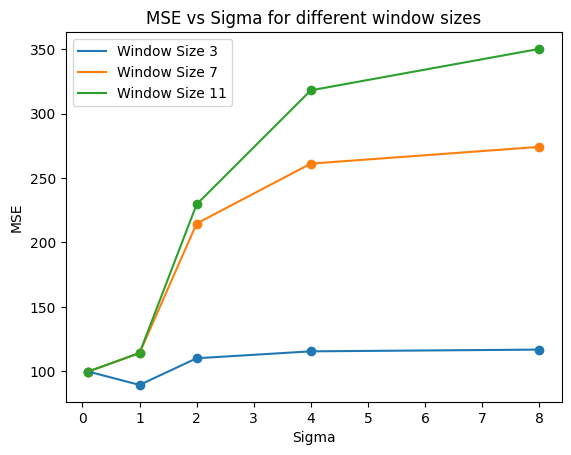

In [14]:
std_dev_list = list(MSE_Values[3].keys())

for size in MSE_Values.keys():
    mse_values = list(MSE_Values[size].values())
    plt.plot(std_dev_list, mse_values, label=f'Window Size {size}')
    plt.scatter(std_dev_list, mse_values)  # This line adds the dots

plt.xlabel('Sigma')
plt.ylabel('MSE')
plt.title('MSE vs Sigma for different window sizes')
plt.legend()
plt.show()

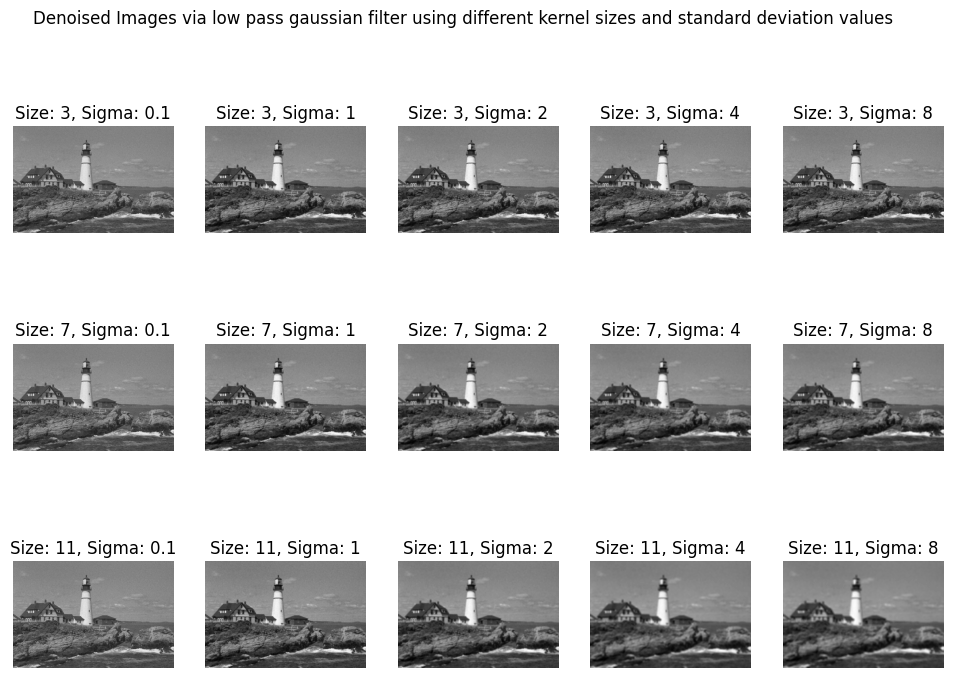

In [15]:
Image_stack = question_2a.image_stack

fig,axs = plt.subplots(len(kernel_size_list),len(std_dev_list),figsize = (12,8))

for i,size in enumerate(kernel_size_list):
  for j,sigma in enumerate(std_dev_list):
    axs[i][j].imshow(Image_stack[size][sigma],cmap = 'gray')
    axs[i][j].axis('off')
    axs[i][j].set_title(f'Size: {size}, Sigma: {sigma}')

fig.suptitle('Denoised Images via low pass gaussian filter using different kernel sizes and standard deviation values')

plt.show()


## **Question 2**,Part 2:

In [16]:
class AdaptiveMMSE:
    def __init__(self, noisy_image, size = min_MSE[1], sigma = min_MSE[2], var_z=100, patch_size=32, step=16):
        self.noisy_image = noisy_image
        self.size = size
        self.sigma = sigma
        self.var_z = var_z
        self.patch_size = patch_size
        self.step = step
        self.height, self.width = noisy_image.shape

    def high_pass_filter(self):
      # Original Noisy Image
      y = self.noisy_image

      # Low pass domain of the image
      miu_y = cv2.GaussianBlur(y.copy(),(self.size, self.size),self.sigma)

      # Obtain Noise Kernel
      gaussian_kernel_x = cv2.getGaussianKernel(self.size,self.sigma)
      gaussian_kernel_y = cv2.getGaussianKernel(self.size,self.sigma)
      gaussian_kernel = np.outer(gaussian_kernel_x,gaussian_kernel_y)

      # High pass domain of the image
      y1 = y - miu_y

      return y1, miu_y, gaussian_kernel

    def compute_aMMSE(self):
      y1, miu_y, gaussian_kernel = self.high_pass_filter()
      temp_matrix = np.zeros_like(y1)
      count_matrix = np.zeros_like(y1,dtype=int)

      # Iterate over the image
      for i in range(0,self.height-self.patch_size+1,self.step):
          for j in range(0,self.width-self.patch_size+1,self.step):
              # Define patch:
              patch = y1[i:i+self.patch_size,j:j+self.patch_size]

              # Computing Variances
              var_y1 = np.var(patch)
              var_z1 = self.var_z * (1 - 2*gaussian_kernel[int((self.size - 1)/2)][int((self.size - 1)/2)] + np.sum(np.square(gaussian_kernel)))
              var_x1 = var_y1 - var_z1

              # Iterate over the patch
              patch_height,patch_width = patch.shape
              for p in range(patch_height):
                  for q in range(patch_width):
                      temp_matrix[i + p][j + q] += (var_x1/(var_x1 + var_z1)) * y1[i + p][j + q]
                      count_matrix[i + p][j + q] += 1

      x1_estimate = temp_matrix/count_matrix
      estimate_aMMSE = miu_y + x1_estimate

      return estimate_aMMSE


In [17]:
size = 3
sigma = 1
adaptive_mmse = AdaptiveMMSE(noisy_image,size,sigma)
image_AMMSE = adaptive_mmse.compute_aMMSE()
print(f"MSE using adaptive MMSE is {np.round(np.mean((grayscale_image.astype('float') - image_AMMSE.astype('float'))**2),4)} (Using kernel size {size}x{size} and standard deviation {sigma})")

MSE using adaptive MMSE is 41.8734 (Using kernel size 3x3 and standard deviation 1)


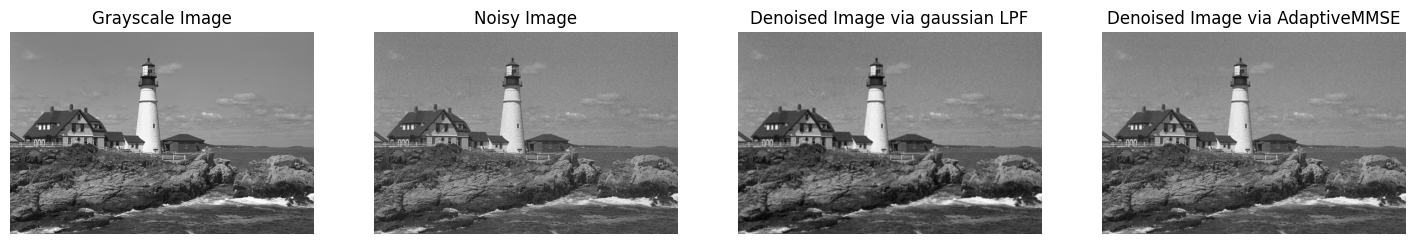

In [18]:
# Displaying
fig,axs = plt.subplots(1,4,figsize = (18,10))

axs[0].imshow(grayscale_image, cmap = 'gray')
axs[0].axis('off')
axs[0].set_title('Grayscale Image')

axs[1].imshow(noisy_image, cmap = 'gray')
axs[1].axis('off')
axs[1].set_title('Noisy Image')

axs[2].imshow(cv2.GaussianBlur(noisy_image.copy(),(min_MSE[1], min_MSE[1]),min_MSE[2]), cmap = 'gray')
axs[2].axis('off')
axs[2].set_title('Denoised Image via gaussian LPF')

axs[3].imshow(image_AMMSE, cmap = 'gray')
axs[3].axis('off')
axs[3].set_title('Denoised Image via AdaptiveMMSE')

plt.show()

#### **Comparison:**

In [19]:
kernel_size_list = [3, 7, 11]
std_dev_list =  [1, 2, 4, 8]

final_MSE_list = []
final_image_stack = []
for size in kernel_size_list:
  MSE_list = []
  image_stack = []
  for sigma in std_dev_list:
    adaptive_mmse = AdaptiveMMSE(noisy_image,size,sigma)
    image_AMMSE = adaptive_mmse.compute_aMMSE()
    image_stack.append(image_AMMSE)

    mse = np.round(np.mean((grayscale_image.astype('float') - image_AMMSE.astype('float'))**2),4)
    MSE_list.append(mse)

  final_MSE_list.append(MSE_list)
  final_image_stack.append(image)

In [20]:
for kernel_size, MSE_list in zip(kernel_size_list, final_MSE_list):
    print(f"For kernel size {kernel_size}")
    # Iterate over each standard deviation and its corresponding MSE
    for std_dev, MSE in zip(std_dev_list, MSE_list):
        print(f"Standard deviation is {std_dev} and MSE is: {MSE}")

For kernel size 3
Standard deviation is 1 and MSE is: 41.8734
Standard deviation is 2 and MSE is: 41.7742
Standard deviation is 4 and MSE is: 41.9181
Standard deviation is 8 and MSE is: 41.9626
For kernel size 7
Standard deviation is 1 and MSE is: 41.9308
Standard deviation is 2 and MSE is: 44.2337
Standard deviation is 4 and MSE is: 45.6884
Standard deviation is 8 and MSE is: 46.1035
For kernel size 11
Standard deviation is 1 and MSE is: 41.9307
Standard deviation is 2 and MSE is: 44.6606
Standard deviation is 4 and MSE is: 47.2836
Standard deviation is 8 and MSE is: 48.1718


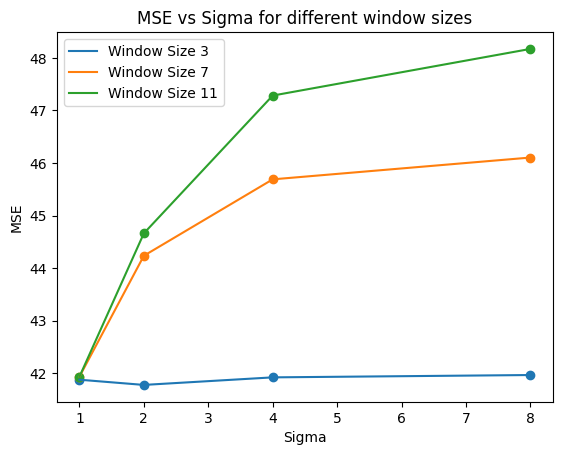

In [21]:
for i in range(len(kernel_size_list)):
    plt.plot(std_dev_list, final_MSE_list[i], label=f'Window Size {kernel_size_list[i]}')
    plt.scatter(std_dev_list, final_MSE_list[i])

plt.xlabel('Sigma')
plt.ylabel('MSE')
plt.title('MSE vs Sigma for different window sizes')
plt.legend()
plt.show()

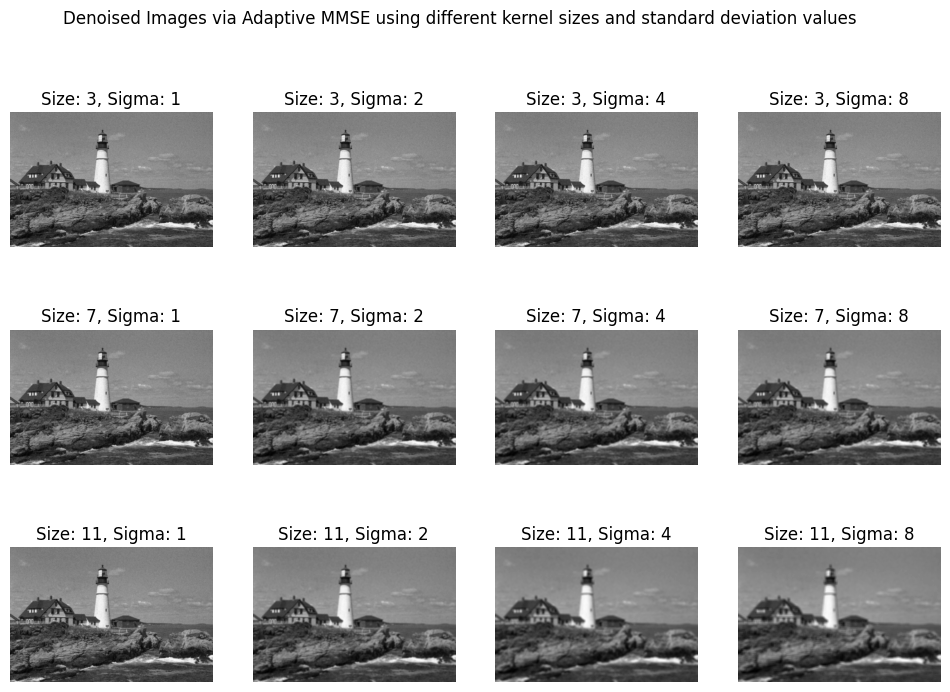

In [22]:
fig,axs = plt.subplots(len(kernel_size_list),len(std_dev_list),figsize = (12,8))

for i,size in enumerate(kernel_size_list):
  for j,sigma in enumerate(std_dev_list):
    axs[i][j].imshow(Image_stack[size][sigma],cmap = 'gray')
    axs[i][j].axis('off')
    axs[i][j].set_title(f'Size: {size}, Sigma: {sigma}')

fig.suptitle('Denoised Images via Adaptive MMSE using different kernel sizes and standard deviation values')

plt.show()

## **Question 2**,Part 3:

In [23]:
class AdaptiveShrinkage:
    def __init__(self, noisy_image, size, sigma, var_z=100, patch_size=32, step=8):
        self.noisy_image = noisy_image
        self.size = size
        self.sigma = sigma
        self.var_z = var_z
        self.patch_size = patch_size
        self.step = step

    def compute_and_implement_threshold(self, patch, var):
        opt_t = 0
        min_error = float('inf')
        t_values = np.linspace(0,100,100)
        for t in t_values:
            estimate = np.sum(np.square((np.minimum(patch,t)))) - 2* var * np.sum(np.abs(patch) < t)

            if estimate < min_error:
                min_error = estimate
                opt_t = t

        thresholded_patch = np.sign(patch) * np.maximum(0, np.abs(patch) - opt_t)
        return thresholded_patch

    def compute_aShrinkage(self):
        y = self.noisy_image
        miu_y = cv2.GaussianBlur(y.copy(),(self.size, self.size),self.sigma)

        gaussian_kernel_x = cv2.getGaussianKernel(self.size,self.sigma)
        gaussian_kernel_y = cv2.getGaussianKernel(self.size,self.sigma)
        gaussian_kernel = np.outer(gaussian_kernel_x,gaussian_kernel_y)
        gaussian_kernel[int((self.size - 1)/2)][int((self.size - 1)/2)] -= 1
        var_z1 = np.sum(np.square(gaussian_kernel)) * self.var_z

        y1 = y - miu_y
        sum_matrix = np.zeros_like(y1)
        count_matrix = np.zeros_like(y1,dtype=int)

        height, width = y1.shape

        for i in range(0, height-self.patch_size+1, self.step):
            for j in range(0, width-self.patch_size+1, self.step):
                patch = y1[i:i+self.patch_size, j:j+self.patch_size]
                thresholded_patch = self.compute_and_implement_threshold(patch,var_z1)
                sum_matrix[i:i+self.patch_size, j:j+self.patch_size] += thresholded_patch
                count_matrix[i:i+self.patch_size, j:j+self.patch_size] += 1

        x1_estimate = sum_matrix / count_matrix
        estimate_sureshrink = miu_y + x1_estimate

        return estimate_sureshrink


In [24]:
size = 3
sigma = 1
adaptive_shrinkage = AdaptiveShrinkage(noisy_image,size,sigma)
image_AShrinkage = adaptive_shrinkage.compute_aShrinkage()
print(f"MSE using adaptive MMSE is {np.round(np.mean((grayscale_image.astype('float') - image_AShrinkage.astype('float'))**2),4)} (Using kernel size {size}x{size} and standard deviation {sigma})")

MSE using adaptive MMSE is 49.508 (Using kernel size 3x3 and standard deviation 1)


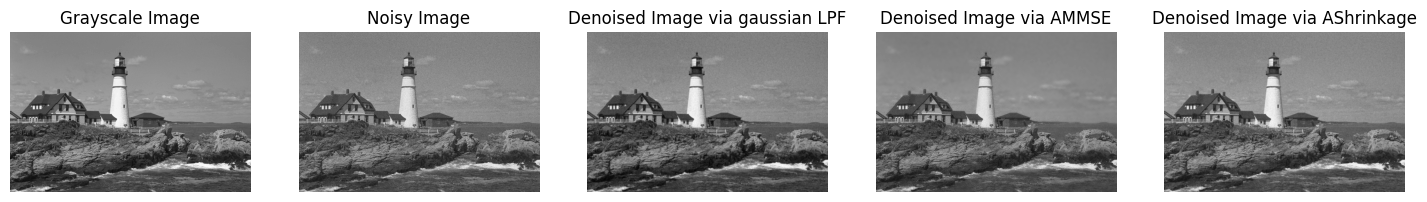

In [25]:
# Displaying
fig,axs = plt.subplots(1,5,figsize = (18,10))

axs[0].imshow(grayscale_image, cmap = 'gray')
axs[0].axis('off')
axs[0].set_title('Grayscale Image')

axs[1].imshow(noisy_image, cmap = 'gray')
axs[1].axis('off')
axs[1].set_title('Noisy Image')

axs[2].imshow(cv2.GaussianBlur(noisy_image.copy(),(min_MSE[1], min_MSE[1]),min_MSE[2]), cmap = 'gray')
axs[2].axis('off')
axs[2].set_title('Denoised Image via gaussian LPF')

axs[3].imshow(image_AMMSE, cmap = 'gray')
axs[3].axis('off')
axs[3].set_title('Denoised Image via AMMSE')

axs[4].imshow(image_AShrinkage, cmap = 'gray')
axs[4].axis('off')
axs[4].set_title('Denoised Image via AShrinkage')

plt.show()

#### **Comparison** :


In [26]:
kernel_size_list = [3, 7, 11]
std_dev_list =  [1, 2, 4, 8]

final_MSE_list = []
final_image_stack = []
for size in kernel_size_list:
  MSE_list = []
  image_stack = []
  for sigma in std_dev_list:
    adaptive_shrinkage = AdaptiveShrinkage(noisy_image,size,sigma)
    image_AShrinkage = adaptive_shrinkage.compute_aShrinkage()
    image_stack.append(image_AShrinkage)

    mse = np.round(np.mean((grayscale_image.astype('float') - image_AShrinkage.astype('float'))**2),4)
    MSE_list.append(mse)

  final_MSE_list.append(MSE_list)
  final_image_stack.append(image)

In [27]:
for kernel_size, MSE_list in zip(kernel_size_list, final_MSE_list):
    print(f"For kernel size {kernel_size}")
    # Iterate over each standard deviation and its corresponding MSE
    for std_dev, MSE in zip(std_dev_list, MSE_list):
        print(f"Standard deviation is {std_dev} and MSE is: {MSE}")

For kernel size 3
Standard deviation is 1 and MSE is: 49.508
Standard deviation is 2 and MSE is: 53.7911
Standard deviation is 4 and MSE is: 54.9609
Standard deviation is 8 and MSE is: 55.318
For kernel size 7
Standard deviation is 1 and MSE is: 49.9902
Standard deviation is 2 and MSE is: 56.625
Standard deviation is 4 and MSE is: 58.9565
Standard deviation is 8 and MSE is: 59.5912
For kernel size 11
Standard deviation is 1 and MSE is: 49.992
Standard deviation is 2 and MSE is: 57.3873
Standard deviation is 4 and MSE is: 60.7473
Standard deviation is 8 and MSE is: 61.4892


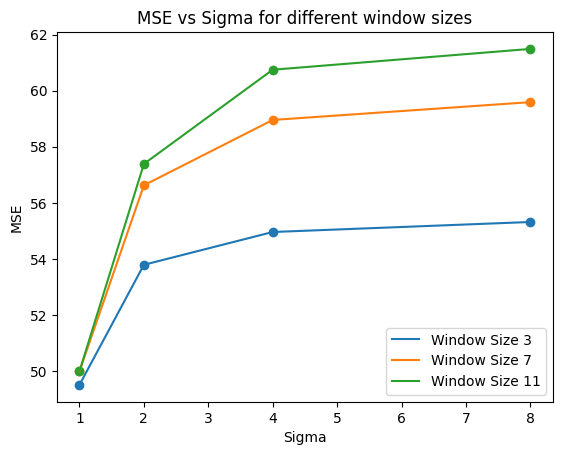

In [28]:
for i in range(len(kernel_size_list)):
    plt.plot(std_dev_list, final_MSE_list[i], label=f'Window Size {kernel_size_list[i]}')
    plt.scatter(std_dev_list, final_MSE_list[i])

plt.xlabel('Sigma')
plt.ylabel('MSE')
plt.title('MSE vs Sigma for different window sizes')
plt.legend()
plt.show()

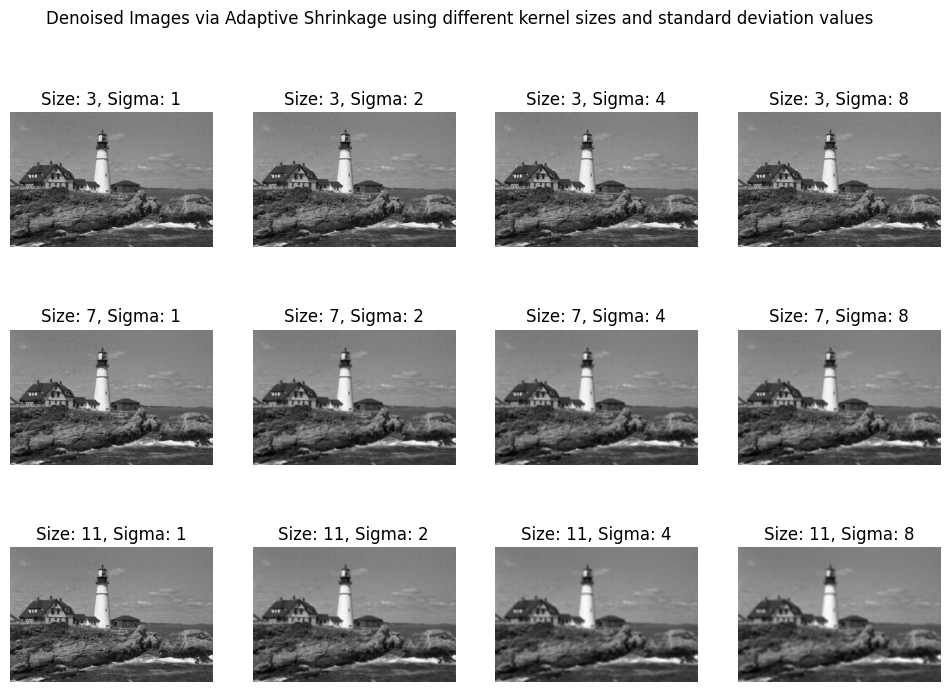

In [29]:
fig,axs = plt.subplots(len(kernel_size_list),len(std_dev_list),figsize = (12,8))

for i,size in enumerate(kernel_size_list):
  for j,sigma in enumerate(std_dev_list):
    axs[i][j].imshow(Image_stack[size][sigma],cmap = 'gray')
    axs[i][j].axis('off')
    axs[i][j].set_title(f'Size: {size}, Sigma: {sigma}')

fig.suptitle('Denoised Images via Adaptive Shrinkage using different kernel sizes and standard deviation values')

plt.show()